In [1]:
import numpy as np
import pandas as pd

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import Dropout

from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.impute import KNNImputer

In [2]:
# Data Read
train_clinical = pd.read_csv("/kaggle/input/amp-parkinsons-disease-progression-prediction/train_clinical_data.csv")
train_protein = pd.read_csv("/kaggle/input/amp-parkinsons-disease-progression-prediction/train_proteins.csv")
train_peptide = pd.read_csv("/kaggle/input/amp-parkinsons-disease-progression-prediction/train_peptides.csv")

In [3]:
# Create Targets

patients = {}
for e in range(1,5):
    for m in [0,6,12,24]:
        train_clinical[f'updrs_{e}_plus_{m}_months'] = 0

for patient in train_clinical.patient_id.unique():
    temp = train_clinical[train_clinical.patient_id == patient]
    month_list = []
    month_windows = [0,6,12,24]
    for month in temp.visit_month.values:
        month_list.append([month, month + 6, month + 12, month + 24])
    for month in range(len(month_list)):
        for x in range(1,5):
            arr = temp[temp.visit_month.isin(month_list[month])][f'updrs_{x}'].fillna(0).to_list()
            if len(arr) == 4:
                for e, i in enumerate(arr):
                    m = month_list[month][0]
                    temp.loc[temp.visit_month == m,[f'updrs_{x}_plus_{month_windows[e]}_months']] = i
            else:
                temp = temp[~temp.visit_month.isin(month_list[month])]
    patients[patient] = temp

/opt/conda/lib/python3.7/site-packages/pandas/core/indexing.py:1817: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_column(loc, value, pi)


In [4]:
formatted_response = pd.concat(patients.values(), ignore_index=True).set_index('visit_id').iloc[:,7:]
formatted_response.head()

,updrs_1_plus_0_months,updrs_1_plus_6_months,updrs_1_plus_12_months,updrs_1_plus_24_months,updrs_2_plus_0_months,updrs_2_plus_6_months,updrs_2_plus_12_months,updrs_2_plus_24_months,updrs_3_plus_0_months,updrs_3_plus_6_months,updrs_3_plus_12_months,updrs_3_plus_24_months,updrs_4_plus_0_months,updrs_4_plus_6_months,updrs_4_plus_12_months,updrs_4_plus_24_months
visit_id,,,,,,,,,,,,,,,,
55_0,10,8,10,16,6,10,10,9,15,34,41,49,0,0,0,0
55_6,8,10,7,14,10,10,13,13,34,41,38,49,0,0,0,0
55_12,10,7,16,17,10,13,9,18,41,38,49,51,0,0,0,0
55_18,7,16,14,12,13,9,13,20,38,49,49,41,0,0,0,0
55_24,16,14,17,17,9,13,18,16,49,49,51,52,0,0,0,0


In [5]:
# Data cleaning recipe. 

def recipe(clinical, protein, peptide, verbose = True, rep = True):
    if verbose: print('Preprocessing Steps')
    
    # Peptitde Abundance / Protein Expression 
    pep_over_pro = pd.merge(protein, peptide, 
                        on =['visit_id', 'visit_month', 'patient_id', 
                            'UniProt']) # joins the peptide and protein dataset

    # Creates feature in new column
    pep_over_pro['pep_per_pro'] = pep_over_pro['PeptideAbundance'] / pep_over_pro['NPX']
    
    if verbose: print('1. Add Peptide/Protein as new feature.')
    
    # Pivot the data to wide format. 
    pep_over_pro = pep_over_pro.drop(['patient_id', 'visit_month'], axis = 1).pivot(
    index = ['visit_id'], columns = ['Peptide'], values = ['pep_per_pro'])
    
    # Cleans erronous levels for smooth merge. 
    pep_over_pro.columns = pep_over_pro.columns.droplevel()
    pep_over_pro.reset_index()

    train = pd.merge(clinical, pep_over_pro, on = 'visit_id', 
                 how = 'left') # left join
    
    train = train.set_index('visit_id') # removes as feature, but in rowname for tracking

    # Change medication status to a dummy variable 0 = Off; 1 = On
    #train = train.rename(columns = {'upd23b_clinical_state_on_medication': 'med_status'})
    #train = pd.get_dummies(train, columns = ['med_status'])

    #if verbose: print('2. One-hot encoded med_status')
    
    # Drop med_status as a predictor (DOES NOT APPEAR IN TEST DATA)
    if rep:
        train = train.drop(['upd23b_clinical_state_on_medication'], axis = 1)
    
        if verbose: print('2. Dropped med_status as a predictor.')
        
    # Drop patient_id as a predictor 
    train = train.drop(['patient_id'], axis = 1)
    
    if verbose: print('3. Dropped patient_id as a predictor.')
    
    ## KNN Imputation ## 
    
    # Drops the response if it training data.
    if rep: 
        response = train[['updrs_1', 'updrs_2', 'updrs_3', 'updrs_4']]
        train = train.drop(['updrs_1', 'updrs_2', 'updrs_3', 'updrs_4'], axis = 1)
    
    # Drops the categorical variables. 
    cats = train[['visit_month']]
    train = train.drop(['visit_month'], axis = 1)
    
    # Standardize numeric features. 
    scalar = StandardScaler()
    train = pd.DataFrame(scalar.fit_transform(train), columns = train.columns,
                        index = train.index)
    
    if verbose: print('4. Normalized numeric predictors.')
    
    # Add back in cats 
    train = train.join(cats)
    
    # Add unseens in testings as nan (need different imputer for much missing)
    #if not rep:
    #    test_add = np.setdiff1d(X.columns, 
    #                           train.columns).tolist()
    #    
    #    temp = pd.DataFrame(np.nan, 
    #                        columns = test_add, 
    #                        index = train.index)
    #    train = train.join(temp)
        
    # Apply KNN imputation 
    imputer = KNNImputer(n_neighbors = 5)
    train = pd.DataFrame(imputer.fit_transform(train), columns = train.columns, 
                        index = train.index)
    if rep: 
        response = pd.DataFrame(imputer.fit_transform(response), 
                                columns = response.columns, 
                                index = response.index)
    
    if verbose: print('5. KNN Imputation')
    
    # Add back in repsonse if training data. 
    if rep: 
        train = train.join(response)
    
    return train 

In [6]:
# Test recipe 
train_clinical_fresh = pd.read_csv("/kaggle/input/amp-parkinsons-disease-progression-prediction/train_clinical_data.csv")
clean_test = recipe(train_clinical_fresh, train_protein, train_peptide, rep = True)
clean_test.head()

Preprocessing Steps
1. Add Peptide/Protein as new feature.
2. Dropped med_status as a predictor.
3. Dropped patient_id as a predictor.
4. Normalized numeric predictors.
5. KNN Imputation


,AADDTWEPFASGK,AAFGQGSGPIMLDEVQC(UniMod_4)TGTEASLADC(UniMod_4)K,AAFTEC(UniMod_4)C(UniMod_4)QAADK,AANEVSSADVK,AATGEC(UniMod_4)TATVGKR,AATVGSLAGQPLQER,AAVYHHFISDGVR,ADDKETC(UniMod_4)FAEEGK,ADDKETC(UniMod_4)FAEEGKK,ADDLGKGGNEESTKTGNAGSR,...,YVNKEIQNAVNGVK,YWGVASFLQK,YYC(UniMod_4)FQGNQFLR,YYTYLIMNK,YYWGGQYTWDMAK,visit_month,updrs_1,updrs_2,updrs_3,updrs_4
visit_id,,,,,,,,,,,,,,,,,,,,,
55_0,-0.097394,-0.611465,-0.482302,0.0,0.555718,0.388845,-0.055969,-1.188915,0.747080,0.138628,...,-0.235448,0.130248,-0.254317,-0.447802,-0.635128,0.0,10.0,6.0,15.0,2.8
55_3,-0.474096,-1.122953,-0.650454,0.0,-0.309951,0.157413,1.547536,0.143963,-0.820133,0.551960,...,0.933085,2.673593,1.413008,0.661591,0.246301,3.0,10.0,7.0,25.0,3.0
55_6,-0.236887,-0.887478,-0.043868,0.0,1.775712,0.125236,-0.082369,-1.187405,1.221974,0.103260,...,-0.578775,0.200504,-0.661579,-0.292764,-0.010148,6.0,8.0,10.0,34.0,3.4
55_9,0.249475,-1.713341,-0.572966,0.0,-0.329779,-0.103017,0.411495,-0.068773,-0.922437,0.856256,...,0.533902,0.592032,1.609423,-2.001862,-0.192085,9.0,8.0,9.0,30.0,0.0
55_12,-0.313668,-0.911808,-0.261373,0.0,0.110614,0.979999,-0.402378,-1.176289,0.379146,0.155990,...,0.226678,0.498383,-0.876679,0.069697,0.191490,12.0,10.0,10.0,41.0,0.0


In [7]:
# Drop Response from Features Space 
clean_test = clean_test.drop(['updrs_1', 'updrs_2', 'updrs_3', 'updrs_4'], axis = 1)

# Merge Cleaned features with formatted response variables. 
df = clean_test.merge(formatted_response, left_index = True,
                      right_index = True, how = 'right')

# Reset index to be visit month. 
df['visit_month'] = df.reset_index().visit_id.str.split('_').apply(lambda x: int(x[1])).values

df.head()

,AADDTWEPFASGK,AAFGQGSGPIMLDEVQC(UniMod_4)TGTEASLADC(UniMod_4)K,AAFTEC(UniMod_4)C(UniMod_4)QAADK,AANEVSSADVK,AATGEC(UniMod_4)TATVGKR,AATVGSLAGQPLQER,AAVYHHFISDGVR,ADDKETC(UniMod_4)FAEEGK,ADDKETC(UniMod_4)FAEEGKK,ADDLGKGGNEESTKTGNAGSR,...,updrs_2_plus_12_months,updrs_2_plus_24_months,updrs_3_plus_0_months,updrs_3_plus_6_months,updrs_3_plus_12_months,updrs_3_plus_24_months,updrs_4_plus_0_months,updrs_4_plus_6_months,updrs_4_plus_12_months,updrs_4_plus_24_months
visit_id,,,,,,,,,,,,,,,,,,,,,
55_0,-0.097394,-0.611465,-0.482302,0.0,0.555718,0.388845,-0.055969,-1.188915,0.747080,0.138628,...,10,9,15,34,41,49,0,0,0,0
55_6,-0.236887,-0.887478,-0.043868,0.0,1.775712,0.125236,-0.082369,-1.187405,1.221974,0.103260,...,13,13,34,41,38,49,0,0,0,0
55_12,-0.313668,-0.911808,-0.261373,0.0,0.110614,0.979999,-0.402378,-1.176289,0.379146,0.155990,...,9,18,41,38,49,51,0,0,0,0
55_18,0.396631,-0.326973,-0.324320,0.0,0.388457,-1.181958,0.980528,0.740027,-0.336530,-0.299770,...,13,20,38,49,49,41,0,0,0,0
55_24,0.531386,-0.032360,-0.290160,0.0,-0.297339,1.533518,0.013494,-0.397162,-0.271414,0.690600,...,18,16,49,49,51,52,0,0,0,0


In [8]:
# Split into X and y 
X = df[clean_test.columns]
y = df[formatted_response.columns]
y = y.astype('float')

input_shape = [X.shape[1]]

model = tf.keras.Sequential()
model.add(Dense(200, input_shape = input_shape, activation = 'relu'))
model.add(Dense(600, activation = 'relu'))
model.add(Dense(100, activation = 'relu'))
model.add(Dense(900, activation = 'relu'))
model.add(Dense(1000, activation = 'relu'))
model.add(Dense(400, activation = 'relu'))
model.add(Dense(700, activation = 'relu'))
model.add(Dense(800, activation = 'relu'))
model.add(Dense(300, activation = 'relu'))
model.add(Dropout(0.2))
model.add(Dense(y.shape[1]))
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 200)               194000    
                                                                 
 dense_1 (Dense)             (None, 600)               120600    
                                                                 
 dense_2 (Dense)             (None, 100)               60100     
                                                                 
 dense_3 (Dense)             (None, 900)               90900     
                                                                 
 dense_4 (Dense)             (None, 1000)              901000    
                                                                 
 dense_5 (Dense)             (None, 400)               400400    
                                                                 
 dense_6 (Dense)             (None, 700)               2

In [9]:
import tensorflow.keras.backend as K

def smape_loss(y_true, y_pred):
    epsilon = 0.1
    numer = K.abs(y_pred - y_true)
    denom = K.maximum(K.abs(y_true) + K.abs(y_pred) + epsilon, 0.5 + epsilon)
    smape = numer / (denom/2)
    smape = tf.where(tf.math.is_nan(smape), tf.zeros_like(smape), smape)
    return smape


def calculate_smape(y_true, y_pred):
    y_true, y_pred = np.array(y_true), np.array(y_pred)
    
    numer = np.round(np.abs(y_pred-y_true),0)
    denom = np.round(np.abs(y_true) + np.abs(y_pred),0)

    return 1/len(y_true) * np.sum(np.nan_to_num(numer / (denom/2))) *100

In [10]:
learning_rate_fn = keras.optimizers.schedules.PiecewiseConstantDecay(
        boundaries = [500], values = [0.01, 0.001])

model.compile(keras.optimizers.Adam(learning_rate = learning_rate_fn), 
              loss = smape_loss)

Epoch 1/300
27/27 [==============================] - 3s 35ms/step - loss: 1.1903 - val_loss: 1.0259
Epoch 2/300
27/27 [==============================] - 1s 25ms/step - loss: 0.9432 - val_loss: 0.8996
Epoch 3/300
27/27 [==============================] - 1s 34ms/step - loss: 0.9066 - val_loss: 0.8765
Epoch 4/300
27/27 [==============================] - 1s 29ms/step - loss: 0.9024 - val_loss: 0.9159
Epoch 5/300
27/27 [==============================] - 1s 25ms/step - loss: 0.9119 - val_loss: 0.8966
Epoch 6/300
27/27 [==============================] - 1s 25ms/step - loss: 0.8888 - val_loss: 0.8462
Epoch 7/300
27/27 [==============================] - 1s 25ms/step - loss: 0.8673 - val_loss: 0.8583
Epoch 8/300
27/27 [==============================] - 1s 25ms/step - loss: 0.8693 - val_loss: 0.8585
Epoch 9/300
27/27 [==============================] - 1s 25ms/step - loss: 0.8730 - val_loss: 0.8480
Epoch 10/300
27/27 [==============================] - 1s 25ms/step - loss: 0.8622 - val_loss: 0.8669

<AxesSubplot:>

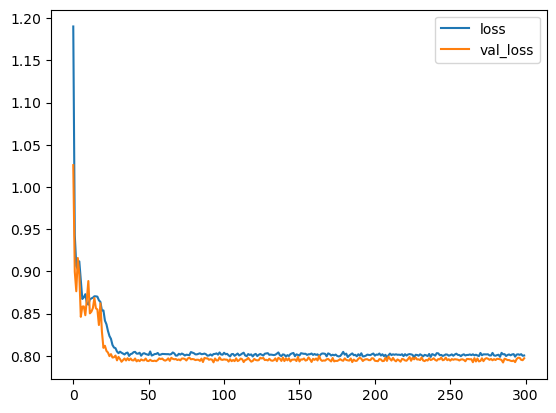

In [11]:
from keras.utils.vis_utils import plot_model
history = model.fit(
    X,
    y,
    epochs = 300,
    validation_split = 0.1
)

pd.DataFrame(history.history).plot()

In [12]:
test_proteins = pd.read_csv('/kaggle/input/amp-parkinsons-disease-progression-prediction/example_test_files/test_proteins.csv') 
test_peptides = pd.read_csv('/kaggle/input/amp-parkinsons-disease-progression-prediction/example_test_files/test_peptides.csv') 
sample_submission = pd.read_csv('/kaggle/input/amp-parkinsons-disease-progression-prediction/example_test_files/sample_submission.csv')
clinical = pd.read_csv('/kaggle/input/amp-parkinsons-disease-progression-prediction/example_test_files/test.csv')

In [13]:
protein = test_proteins
peptides = test_peptides
# Match input format.
clinical = clinical[['patient_id', 'visit_month', 'visit_id']]
protein = protein.drop('group_key', axis = 1)
peptides = peptides.drop('group_key', axis = 1)
    
# Add empty columns for unseen during testing. 
protein_adds = np.setdiff1d(train_protein.columns, protein.columns).tolist()
protein[protein_adds] = np.nan
peptides_adds = np.setdiff1d(train_peptide.columns, peptides.columns).tolist()
peptides[peptides_adds] = np.nan

protein_adds

[]

In [14]:
def prepare_features(clinical, protein, peptides):
    
    # Match input format.
    clinical = clinical[['patient_id', 'visit_month', 'visit_id']]
    protein = protein.drop('group_key', axis = 1, errors = 'ignore')
    peptides = peptides.drop('group_key', axis = 1, errors = 'ignore')
    
    # Apply recipe. 
    clean = recipe(clinical, protein, peptides, rep = False)
    
    # Drop duplicate rows.
    clean = clean[~clean.index.duplicated(keep='first')]
    
    # Add features not seen during testing as 0.
    test_add = np.setdiff1d(X.columns, 
                            clean.columns).tolist()
        
    temp = pd.DataFrame(0, 
                        columns = test_add, 
                        index = clean.index)
    clean = clean.join(temp)
    
    # Drop any features not seen during training.
    train_drops = np.setdiff1d(clean.columns, 
                               X.columns).tolist()
    clean = clean.drop(train_drops, axis = 1)
    
    return clean
    

In [15]:
def get_predictions(features, model):
    pred_submission = np.around(np.abs(model.predict(features)),0)
    pred_submission = pd.DataFrame(pred_submission, index = features.index, columns = y.columns)
    return pred_submission

In [16]:
def format_predictions(predictions, sample_submission):
    """Format predictions for submission"""
    pred_submission = pd.DataFrame(predictions.stack())

    # Map predictions to sample_submission
    pred_submission.index = pred_submission.index.map('_'.join)
    pred_submission.columns = ['rating']
    sample_submission.rating = sample_submission.prediction_id.map(pred_submission.rating)
    
    return sample_submission.fillna(1)

In [17]:
test_features = prepare_features(clinical, test_proteins, test_peptides)
test_predictions = get_predictions(test_features, model)
test_submission = format_predictions(test_predictions, sample_submission)
test_submission

Preprocessing Steps
1. Add Peptide/Protein as new feature.
3. Dropped patient_id as a predictor.
4. Normalized numeric predictors.
5. KNN Imputation
1/1 [==============================] - 0s 147ms/step


,prediction_id,rating,group_key
0,3342_0_updrs_1_plus_0_months,7.0,0
1,3342_0_updrs_1_plus_6_months,7.0,0
2,3342_0_updrs_1_plus_12_months,7.0,0
3,3342_0_updrs_1_plus_24_months,8.0,0
4,3342_0_updrs_2_plus_0_months,7.0,0
...,...,...,...
59,50423_6_updrs_3_plus_24_months,25.0,6
60,50423_6_updrs_4_plus_0_months,3.0,6
61,50423_6_updrs_4_plus_6_months,3.0,6
62,50423_6_updrs_4_plus_12_months,0.0,6


In [18]:
import sys
sys.path.append('/kaggle/input/amp-parkinsons-disease-progression-prediction')

In [19]:
import amp_pd_peptide

In [20]:
env = amp_pd_peptide.make_env()   # initialize the environment
amp_pd_peptide.make_env.func_dict['__called__'] = False
iter_test = env.iter_test()    # an iterator which loops over the test files

for (test, test_peptides, test_proteins, sample_submission) in iter_test:
    sub_features = prepare_features(test, test_proteins, test_peptides)
    sub_predictions = get_predictions(sub_features,model)
    submission = format_predictions(sub_predictions, sample_submission)

    env.predict(submission)

This version of the API is not optimized and should not be used to estimate the runtime of your code on the hidden test set.
Preprocessing Steps
1. Add Peptide/Protein as new feature.
3. Dropped patient_id as a predictor.
4. Normalized numeric predictors.
5. KNN Imputation
1/1 [==============================] - 0s 24ms/step
Preprocessing Steps
1. Add Peptide/Protein as new feature.
3. Dropped patient_id as a predictor.
4. Normalized numeric predictors.
5. KNN Imputation
1/1 [==============================] - 0s 24ms/step


In [21]:
pd.read_csv('/kaggle/working/submission.csv')

,prediction_id,rating
0,3342_0_updrs_1_plus_0_months,7.0
1,3342_0_updrs_1_plus_6_months,7.0
2,3342_0_updrs_1_plus_12_months,7.0
3,3342_0_updrs_1_plus_24_months,8.0
4,3342_0_updrs_2_plus_0_months,7.0
...,...,...
59,50423_6_updrs_3_plus_24_months,25.0
60,50423_6_updrs_4_plus_0_months,3.0
61,50423_6_updrs_4_plus_6_months,3.0
62,50423_6_updrs_4_plus_12_months,0.0
